## Vanilla CNN model for EEG data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Project - C147/project/

/content/drive/.shortcut-targets-by-id/1-ZqOst-RT6vlWrAPZPiqbkETxbuIXYY1/Project - C147/project


In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#data preprocessing from discussion 6 and 7 notebooks
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    X = X[:,:,0:1000]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,1000) -> (sample,22,1000/sub_sample) - resultant vec has 400 points - downsampling; performing low pass filtering on EEG signals
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    #first: mean pooling - downsampling method; smoothing
    #second: add Gaussian noise; regularizing effect
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average)) #vertical stacking; 4230 samples after stacking; size of dataset increased; each of dimension 22x500
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + noise addition

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    X = X[:,:,0:1000]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,1000) -> (sample,22,1000/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

## Data Preprocessing to prevent data leakage

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

In [ ]:
#Proper splitting so that training set is split into training and validation sets before applying the preprocessing functions to each to ensure independent preprocessing.
from sklearn.model_selection import train_test_split

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

x_train_prep,y_train_prep = train_data_prep(x_train,y_train,2,2,True)
x_val_prep,y_val_prep = train_data_prep(x_valid,y_valid,2,2,True)
print("Val prep shape=",x_val_prep.shape)
X_test_prep = test_data_prep(X_test)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_val_prep, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train_prep.reshape(x_train_prep.shape[0], x_train_prep.shape[1], x_train_prep.shape[2], 1)
x_valid = x_val_prep.reshape(x_val_prep.shape[0], x_val_prep.shape[1], x_val_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (1865, 22, 1000)
Shape of validation set: (250, 22, 1000)
Shape of training labels: (1865,)
Shape of validation labels: (250,)
Shape of X after trimming: (1865, 22, 1000)
Shape of X after maxpooling: (1865, 22, 500)
Shape of X after averaging+noise and concatenating: (3730, 22, 500)
Shape of X after subsampling and concatenating: (7460, 22, 500)
Shape of Y: (7460,)
Shape of X after trimming: (250, 22, 1000)
Shape of X after maxpooling: (250, 22, 500)
Shape of X after averaging+noise and concatenating: (500, 22, 500)
Shape of X after subsampling and concatenating: (1000, 22, 500)
Shape of Y: (1000,)
Val prep shape= (1000, 22, 500)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 50

In [ ]:
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of training set: (7460, 500, 1, 22)
Shape of validation set: (1000, 500, 1, 22)
Shape of training labels: (7460, 4)
Shape of validation labels: (1000, 4)


In [ ]:
# Building the CNN model using sequential class (similar to CNN models used in discussion 6 and 7)
vanilla_cnn2 = Sequential()
# Conv. block 1
vanilla_cnn2.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(500,1,22)))
vanilla_cnn2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
vanilla_cnn2.add(BatchNormalization())
vanilla_cnn2.add(Dropout(0.6))

# Conv. block 2
vanilla_cnn2.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
vanilla_cnn2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
vanilla_cnn2.add(BatchNormalization())
vanilla_cnn2.add(Dropout(0.6))

# Conv. block 3
vanilla_cnn2.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
vanilla_cnn2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
vanilla_cnn2.add(BatchNormalization())
vanilla_cnn2.add(Dropout(0.6))

# Conv. block 4
vanilla_cnn2.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
vanilla_cnn2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
vanilla_cnn2.add(BatchNormalization())
vanilla_cnn2.add(Dropout(0.6))

# Output layer with Softmax activation
vanilla_cnn2.add(Flatten()) # Flattens the input
vanilla_cnn2.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
vanilla_cnn2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 500, 1, 25)        13775     
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_72 (Ba  (None, 167, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_72 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_73 (Conv2D)          (None, 167, 1, 50)        31300     
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 56, 1, 50)       

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)
# Define EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
# Compiling the model - higher filter sizes
vanilla_cnn2.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
vanilla_cnn2_results = vanilla_cnn2.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True) #callbacks=[early_stopping])



Epoch 1/100
117/117 [==============================] - 4s 13ms/step - loss: 2.1683 - accuracy: 0.2879 - val_loss: 1.3576 - val_accuracy: 0.3090
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 1.7423 - accuracy: 0.3177 - val_loss: 1.4155 - val_accuracy: 0.3210
Epoch 3/100
117/117 [==============================] - 1s 10ms/step - loss: 1.5336 - accuracy: 0.3523 - val_loss: 1.3319 - val_accuracy: 0.3570
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 1.3755 - accuracy: 0.3966 - val_loss: 1.2438 - val_accuracy: 0.4060
Epoch 5/100
117/117 [==============================] - 1s 9ms/step - loss: 1.3091 - accuracy: 0.4323 - val_loss: 1.2425 - val_accuracy: 0.4240
Epoch 6/100
117/117 [==============================] - 1s 9ms/step - loss: 1.2350 - accuracy: 0.4673 - val_loss: 1.1926 - val_accuracy: 0.4540
Epoch 7/100
117/117 [==============================] - 1s 11ms/step - loss: 1.1885 - accuracy: 0.4913 - val_loss: 1.2279 - val_accuracy: 0.4

Best val_accuracy: 0.7050

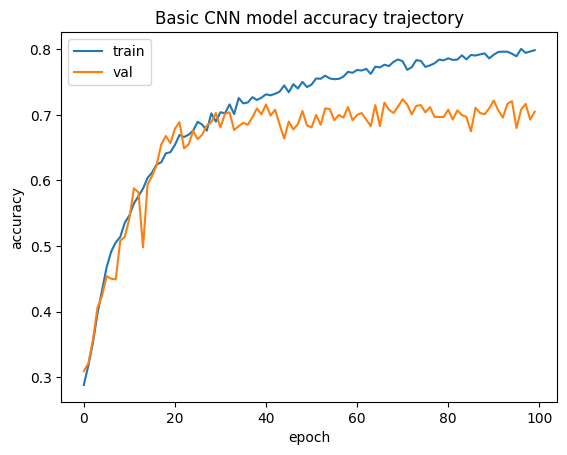

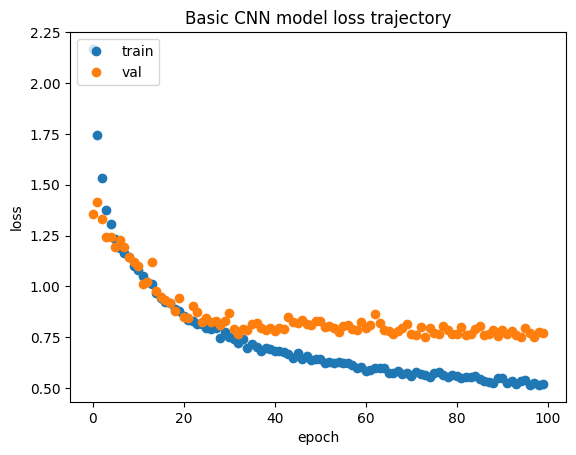

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(vanilla_cnn2_results.history['accuracy'])
plt.plot(vanilla_cnn2_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(vanilla_cnn2_results.history['loss'],'o')
plt.plot(vanilla_cnn2_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the vanilla CNN model

vanilla_cnn2_score = vanilla_cnn2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the vanilla CNN 2 model:',vanilla_cnn2_score[1])

Test accuracy of the vanilla CNN 2 model: 0.7291196584701538


### 72.9% accuracy above with Vanilla CNN (baseline model).

## Hyperparameter tuning for better results

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define a function to create the vanilla CNN model with variable hyperparameters
def create_cnn_model(filters=(25, 50, 100, 200), kernel_size=(5, 5), activation='elu', optimizer='adam', learning_rate=0.001):
  model = Sequential()

  # Conv block 1
  model.add(Conv2D(filters=filters[0], kernel_size=kernel_size, padding='same', activation=activation, input_shape=(500, 1, 22)))
  model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # Conv blocks 2, 3, and 4 (repeated with increasing filter numbers)
  for f in filters[1:]:
    model.add(Conv2D(filters=f, kernel_size=kernel_size, padding='same', activation=activation))
    model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

  # Output layer with Softmax activation
  model.add(Flatten())
  model.add(Dense(4, activation='softmax'))

  # Compile the model with chosen optimizer and learning rate
  if optimizer == 'adam':
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
  else:
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate, momentum=0.9), metrics=['accuracy'])

  return model

# Define hyperparameter search space (example values)
#filter_configs = [(25, 50, 100, 200), (32, 64, 128, 256)]
kernel_sizes = [(5, 5), (10, 10)]
activations = ['elu', 'relu']
#optimizers = ['adam', 'sgd']
#learning_rates = [0.001, 0.0001]

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Loop through hyperparameter combinations and train models
for kernel_size in kernel_sizes:
  for activation in activations:
    # Create and train the model with current hyperparameter combination
    model = create_cnn_model(filters=(25, 50, 100, 200), kernel_size=kernel_size, activation=activation, optimizer='adam', learning_rate=0.001)
    model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=64, callbacks=[early_stopping])

    # Evaluate the model on test data and print results
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Hyperparameters: kernel size - {kernel_size}, activation - {activation}, Test Accuracy - {test_acc:.4f}")




Epoch 1/30
117/117 [==============================] - 4s 13ms/step - loss: 2.2285 - accuracy: 0.2818 - val_loss: 1.3515 - val_accuracy: 0.3500
Epoch 2/30
117/117 [==============================] - 1s 9ms/step - loss: 1.7482 - accuracy: 0.3294 - val_loss: 1.3403 - val_accuracy: 0.3760
Epoch 3/30
117/117 [==============================] - 1s 9ms/step - loss: 1.5161 - accuracy: 0.3578 - val_loss: 1.3273 - val_accuracy: 0.3220
Epoch 4/30
117/117 [==============================] - 1s 9ms/step - loss: 1.3606 - accuracy: 0.4151 - val_loss: 1.4727 - val_accuracy: 0.3260
Epoch 5/30
117/117 [==============================] - 1s 9ms/step - loss: 1.2719 - accuracy: 0.4504 - val_loss: 1.2354 - val_accuracy: 0.4080
Epoch 6/30
117/117 [==============================] - 1s 11ms/step - loss: 1.2235 - accuracy: 0.4769 - val_loss: 1.1488 - val_accuracy: 0.4740
Epoch 7/30
117/117 [==============================] - 1s 11ms/step - loss: 1.1742 - accuracy: 0.5021 - val_loss: 1.1323 - val_accuracy: 0.5170
Epo

Hyperparameters: kernel size - (5, 5), activation - elu, Test Accuracy - 0.6998